In [1]:
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from scipy.stats import zscore

### DataPreprocessing

In [2]:
heart_data_frame = pd.read_csv('heart.csv')
heart_data_frame.head()

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [3]:
num_features = len(heart_data_frame.columns)
num_features

14

In [4]:
print(heart_data_frame.isnull().sum())

age         0
sex         0
cp          0
trtbps      0
chol        0
fbs         0
restecg     0
thalachh    0
exng        0
oldpeak     0
slp         0
caa         0
thall       0
output      0
dtype: int64


In [5]:
def preprocess_inputs(df, label_column):
    df = df.copy()
    
    # Split df into X and y
    Y = df[label_column]
    X = df.drop(label_column, axis=1)
    
    X = X.apply(zscore)
    
    Y = torch.tensor(Y.values, dtype=torch.float32).reshape(-1, 1)
    X = torch.tensor(X.values, dtype=torch.float32)
    
    # Train-test split
    trainX, testX, trainY, testY = train_test_split(X, Y, train_size=0.9, shuffle=True, random_state=1)
    
    return trainX, testX, trainY, testY

In [6]:
trainX, testX, trainY, testY = preprocess_inputs(heart_data_frame, 'output')

In [7]:
trainX, trainY

(tensor([[-0.5918,  0.6810,  0.0320,  ...,  0.9764, -0.7144, -0.5129],
         [-0.1507,  0.6810,  1.0026,  ..., -2.2746, -0.7144, -0.5129],
         [ 0.2905, -1.4684, -0.9385,  ...,  0.9764,  0.2651, -0.5129],
         ...,
         [-2.7976,  0.6810,  0.0320,  ...,  0.9764, -0.7144, -0.5129],
         [-0.3713,  0.6810, -0.9385,  ...,  0.9764, -0.7144,  1.1230],
         [-0.0404,  0.6810,  1.0026,  ...,  0.9764, -0.7144,  1.1230]]),
 tensor([[1.],
         [1.],
         [1.],
         [0.],
         [1.],
         [1.],
         [0.],
         [0.],
         [1.],
         [1.],
         [0.],
         [1.],
         [0.],
         [0.],
         [0.],
         [0.],
         [1.],
         [0.],
         [1.],
         [1.],
         [0.],
         [0.],
         [1.],
         [1.],
         [1.],
         [1.],
         [0.],
         [0.],
         [0.],
         [1.],
         [1.],
         [1.],
         [1.],
         [0.],
         [1.],
         [1.],
         [0.],
   

In [8]:
testX, testY

(tensor([[ 0.8419, -1.4684, -0.9385,  1.6206, -1.5898, -0.4176, -1.0058, -0.2032,
          -0.6966,  4.4519, -2.2746,  2.2241,  1.1230],
         [ 0.1802,  0.6810,  0.0320, -0.0927, -0.4882, -0.4176, -1.0058,  0.5839,
          -0.6966, -0.8969,  0.9764, -0.7144,  1.1230],
         [-0.7021,  0.6810, -0.9385, -0.0927,  0.1882,  2.3944, -1.0058,  0.0154,
           1.4355, -0.8969,  0.9764,  1.2446,  1.1230],
         [ 0.6213,  0.6810, -0.9385, -0.0927, -0.7781, -0.4176, -1.0058, -0.7717,
           1.4355,  1.1736, -0.6491,  1.2446,  1.1230],
         [-0.4816,  0.6810, -0.9385,  1.0495, -0.0631, -0.4176, -1.0058, -0.9466,
          -0.6966,  1.3461, -0.6491, -0.7144,  1.1230],
         [ 0.9522,  0.6810, -0.9385,  0.4784, -1.1453, -0.4176, -1.0058, -0.2469,
           1.4355,  2.5539,  0.9764,  1.2446,  1.1230],
         [ 0.1802,  0.6810, -0.9385, -0.0927,  0.7099,  2.3944, -1.0058, -2.0399,
           1.4355,  0.4835, -2.2746, -0.7144,  1.1230],
         [-0.9227, -1.4684, -0.938

### Model

In [38]:
class BinaryClassifier(nn.Module):
    def __init__(self, input_dim):
        super(BinaryClassifier, self).__init__()

        self.fc1 = nn.Linear(input_dim, 64) 
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.sigmoid(self.fc3(x))
        return x

In [39]:
input_dim = trainX.shape[1]

In [40]:
model = BinaryClassifier(input_dim)
criterion = nn.BCELoss()
optimizer = optim.SGD(model.parameters(), lr = 0.01)

In [41]:
epochs = 1000
losses = []

In [42]:
# training the model
for epoch in range(epochs):
    optimizer.zero_grad()

    outputs = model(trainX)
    loss = criterion(outputs, trainY)
    loss.backward()

    optimizer.step()

    if (epoch + 1) % 100 == 0:
        print(f'Epoch {epoch + 1}/{epochs} - Loss : {loss.item():.4f}')

    losses.append(loss.item())

model.eval()
with torch.no_grad():
    test_outputs = model(testX)
    test_loss = criterion(test_outputs, testY)
    print(f'Test Loss : {test_loss.item():.4f}')


Epoch 100/1000 - Loss : 0.6731
Epoch 200/1000 - Loss : 0.6411
Epoch 300/1000 - Loss : 0.5994
Epoch 400/1000 - Loss : 0.5462
Epoch 500/1000 - Loss : 0.4888
Epoch 600/1000 - Loss : 0.4398
Epoch 700/1000 - Loss : 0.4051
Epoch 800/1000 - Loss : 0.3822
Epoch 900/1000 - Loss : 0.3667
Epoch 1000/1000 - Loss : 0.3551
Test Loss : 0.3069


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


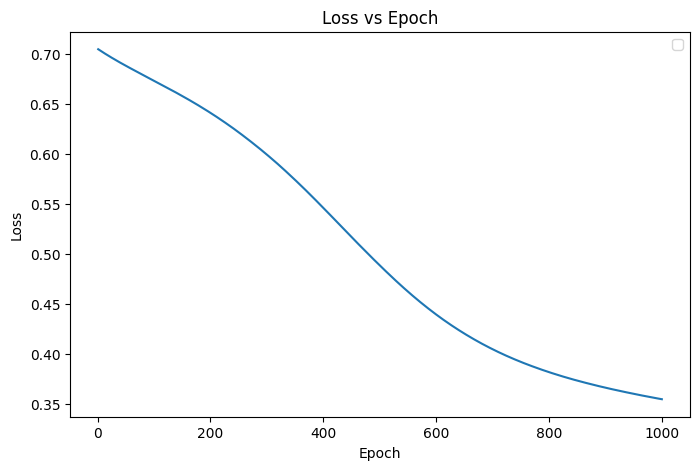

In [43]:
plt.figure(figsize=(8, 5))
plt.plot(range(1, epochs + 1), losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs Epoch')
plt.legend()
plt.show()